In [1]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Global variables
num_trials = 110

## Load and configure FEC and CS timestamp data from one training experiment as dataframe

In [3]:
fec_path = "../../Data/fec/6599TR/training/6599TR_fec_2025-05-19_15-19-38.csv"
stim_path = "../../Data/stim/6599TR/training/6599TR_stim_2025-05-19_15-19-38.csv"
df_fec = pd.read_csv(fec_path)  # df containing eyeblink fraction data
df_stim = pd.read_csv(stim_path)  # df containing timestamp of CS for each trial

# Adjust datatypes in fec dataframe
df_fec["Trial #"] = df_fec["Trial #"].astype(int)  # Convert Trial #'s to ints
df_fec["Timestamp"] = pd.to_datetime(df_fec["Timestamp"])  # Convert fec timestamp strings to datetime
df_fec["FEC"] = df_fec["FEC"].astype(float)  # Convert FEC values to floats

# Adjust datatypes in stim dataframe
df_stim["Trial #"] = df_stim["Trial #"].astype(int)  # Convert Trial #'s to ints
df_stim["CS Timestamp"] = pd.to_datetime(df_stim["CS Timestamp"]) # Convert CS timestamp strings to datetime
df_stim["Airpuff"] = df_stim["Airpuff"].astype(bool)  # Convert Airpuff strings to bool
try:
    df_stim["Tone"] = df_stim["Tone"].astype(int)  # Convert tone strings to ints
except KeyError:
    print("No tone column found in stim dataframe.")
    # If no tone column, do nothing
    pass

In [4]:
print(len(df_fec))  # Print number of timestamps recorded in fec dataframe
df_fec.head()

20392


,Timestamp,Trial #,FEC
0,2025-05-19 15:21:43.572754,1,0.0
1,2025-05-19 15:21:43.605272,1,0.0
2,2025-05-19 15:21:43.655488,1,1.0
3,2025-05-19 15:21:43.686733,1,5.0
4,2025-05-19 15:21:43.733631,1,3.0


In [5]:
print(len(df_stim))  # Should equal num_trials (110 by default)
df_stim.head()

110


,Trial #,CS Timestamp,Airpuff,Tone
0,1,2025-05-19 15:21:43.605272,True,10
1,2,2025-05-19 15:21:57.434754,True,10
2,3,2025-05-19 15:22:16.815466,False,10
3,4,2025-05-19 15:22:30.940848,True,10
4,5,2025-05-19 15:22:47.517171,True,10


In [6]:
# Normalize FEC values [0, 100]
def normalize_fec(fec_series):
    """
    Normalize FEC values to a range of [0, 100].
    """
    fec_min = fec_series.min()
    fec_max = fec_series.max()
    return round(((fec_series - fec_min) / (fec_max - fec_min)) * 100)

# Normalize FEC values
df_fec["FEC"] = normalize_fec(df_fec["FEC"])
df_fec.head()


,Timestamp,Trial #,FEC
0,2025-05-19 15:21:43.572754,1,0.0
1,2025-05-19 15:21:43.605272,1,0.0
2,2025-05-19 15:21:43.655488,1,1.0
3,2025-05-19 15:21:43.686733,1,5.0
4,2025-05-19 15:21:43.733631,1,3.0


### Combine dataframes 

In [7]:
# Merge the dataframes based on the 'Trial #' column
merged_df = pd.merge(df_fec, df_stim, on='Trial #', how='left')

# Calculate timestamps relative to CS onset
merged_df["Relative Timestamp"] = pd.to_timedelta(merged_df["Timestamp"] - merged_df["CS Timestamp"])  # calc and convert to timedeltas
merged_df["Relative Timestamp"] = merged_df["Relative Timestamp"].dt.total_seconds() * 1000  # convert to milliseconds
merged_df.head()

,Timestamp,Trial #,FEC,CS Timestamp,Airpuff,Tone,Relative Timestamp
0,2025-05-19 15:21:43.572754,1,0.0,2025-05-19 15:21:43.605272,True,10,-32.518
1,2025-05-19 15:21:43.605272,1,0.0,2025-05-19 15:21:43.605272,True,10,0.000
2,2025-05-19 15:21:43.655488,1,1.0,2025-05-19 15:21:43.605272,True,10,50.216
3,2025-05-19 15:21:43.686733,1,5.0,2025-05-19 15:21:43.605272,True,10,81.461
4,2025-05-19 15:21:43.733631,1,3.0,2025-05-19 15:21:43.605272,True,10,128.359


## Create graph of "FEC vs. Time from CS onset"

In [8]:
# filter = (merged_df['Relative Timestamp'] >= 0) & (merged_df['Trial #'] == 1)  # Filter for time after CS onset in trial 1
filter = (merged_df['Trial #'] == 1)  # Filter for trial 1 only
df = merged_df[filter]
df.head()

,Timestamp,Trial #,FEC,CS Timestamp,Airpuff,Tone,Relative Timestamp
0,2025-05-19 15:21:43.572754,1,0.0,2025-05-19 15:21:43.605272,True,10,-32.518
1,2025-05-19 15:21:43.605272,1,0.0,2025-05-19 15:21:43.605272,True,10,0.000
2,2025-05-19 15:21:43.655488,1,1.0,2025-05-19 15:21:43.605272,True,10,50.216
3,2025-05-19 15:21:43.686733,1,5.0,2025-05-19 15:21:43.605272,True,10,81.461
4,2025-05-19 15:21:43.733631,1,3.0,2025-05-19 15:21:43.605272,True,10,128.359


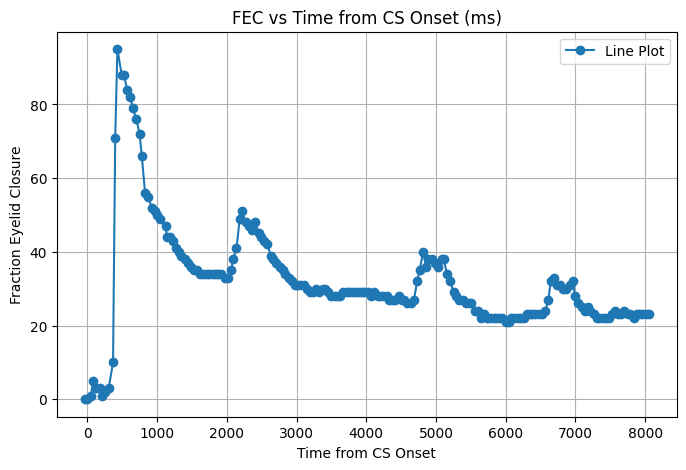

In [9]:
# Create plot
plt.figure(figsize=(8, 5))
plt.plot(df['Relative Timestamp'], df['FEC'], marker='o', label='Line Plot')

plt.xlabel('Time from CS Onset')
plt.ylabel('Fraction Eyelid Closure')
plt.title('FEC vs Time from CS Onset (ms)')
plt.legend()
plt.grid(True)
plt.show()

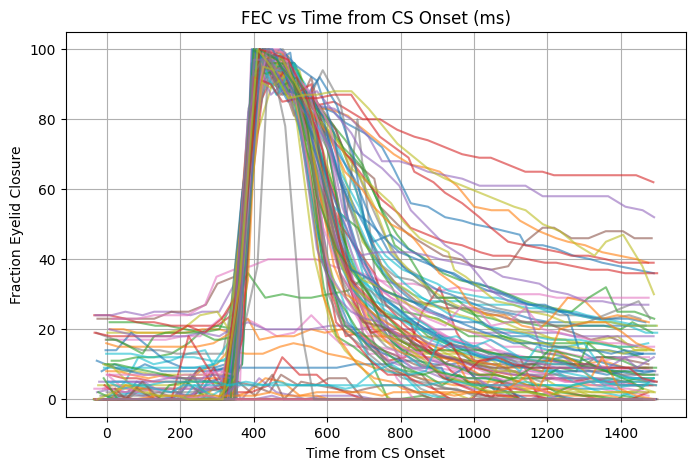

In [10]:
# Overlay graphs from all 110 trials
plt.figure(figsize=(8, 5))
for trial in range(1, 111): # Loop through trials 1 to 110
    filter = (merged_df['Trial #'] == trial) & (-50 < merged_df['Relative Timestamp']) & (merged_df['Relative Timestamp'] <= 1500)  # Filter for trial n only
    df_i = merged_df[filter]
    plt.plot(df_i['Relative Timestamp'], df_i['FEC'], alpha=0.6, label=f'Trial {trial}')

plt.xlabel('Time from CS Onset')
plt.ylabel('Fraction Eyelid Closure')
plt.title('FEC vs Time from CS Onset (ms)')
# plt.legend()
plt.grid(True)
plt.show()

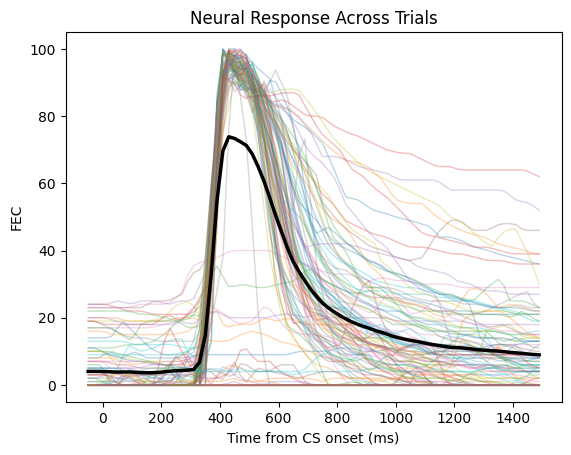

In [11]:
# Interpolate x values to plot mean FEC across trials in one experiment

# Define common x-axis (smooth and finely spaced)
x_common = np.arange(-50, 1500, 20)

# Interpolate each y onto x_common
y_interps = np.zeros((num_trials, len(x_common)))  # Initialize array to hold interpolated values
for trial in range(1, num_trials + 1):  # Loop through trials 1 to 9
    filter = (merged_df['Trial #'] == trial) & (-50 < merged_df['Relative Timestamp']) & (merged_df['Relative Timestamp'] <= 1500)  # Filter for trial n only
    df_i = merged_df[filter]
    if not df_i.empty:
        y_interp = np.interp(x_common, df_i['Relative Timestamp'], df_i['FEC'])
        plt.plot(x_common, y_interp, alpha=0.3, linewidth=1, label=f'Trial {trial}')  # Plot faded individual interpolated curves
        y_interps[trial - 1, :] = y_interp  # Store interpolated values

# Calculate mean across trials
y_mean = np.mean(y_interps, axis=0)

# Plot dark average line
plt.plot(x_common, y_mean, color='black', linewidth=2.5, label='Mean')

# Optional: Add labels, legend, etc.
plt.xlabel("Time from CS onset (ms)")
plt.ylabel("FEC")
plt.title("Neural Response Across Trials")
# plt.legend()
# plt.tight_layout()
plt.show()